In [1]:
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scanpy as sc
import pyranges as pr

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False

In [4]:
%cd ~/workspace/proj/2025/longsc

/home/elly924/workspace/proj/2025/longsc


In [5]:
import sys
sys.path.append('./src/')

In [6]:
import Splicella as spc

In [7]:
RCC1_fc = anndata.read_h5ad('data/RCC1/RCC1_fc.adata.h5ad') #made frome featurecount (gene count)

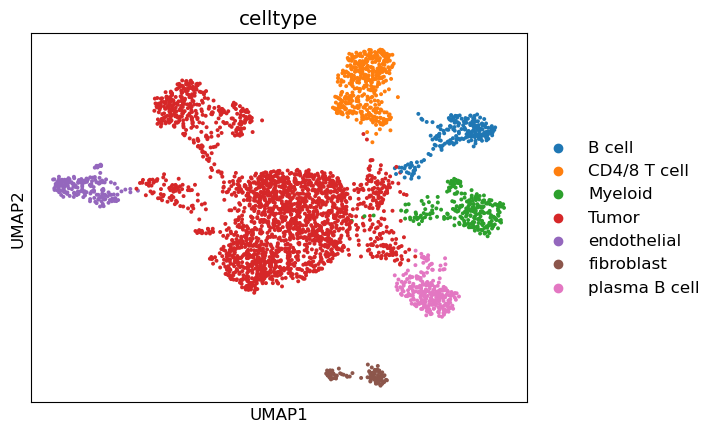

In [8]:
sc.pl.umap(RCC1_fc, color='celltype')

In [9]:
RCC1_fc_ = RCC1_fc.copy()
RCC1_fc_.var = RCC1_fc_.var.reset_index()
RCC1_fc_.var_names = np.array(RCC1_fc_.var['gene_name'])
RCC1_fc_.var_names_make_unique()

In [10]:
anno_tr = spc.utils.get_annotr_fromgtf('refs/gencode.v48.primary_assembly.annotation.gtf.gz')

In [11]:
RCC1_iso_ad = spc.utils.get_adata_from_iso(
    'data/RCC1/scNanoGPS/00_merged.curated.minimap2.transcript_grouped_counts.tsv',
    anno_tr=anno_tr)

In [12]:
RCC1_iso_ad.shape

(3710, 153887)

In [13]:
RCC1_iso_ad.write_h5ad('data/RCC1/RCC1_iso.adata.h5ad')

In [10]:
RCC1_iso_ad = anndata.read_h5ad('data/RCC1/RCC1_iso.adata.h5ad')

In [11]:
RCC1_iso_ad.shape

(3710, 153887)

In [12]:
RCC1_iso_ad_ = spc.utils.filter_isoad(RCC1_iso_ad,
                                      RCC1_fc_,
                                      obs_copy=['celltype'],
                                      uns_copy=['celltype_colors',
                                                'neighbors', 'pca', 'umap'],)

/home/elly924/workspace/proj/2025/longsc/./src/Splicella/utils.py:63: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  iso_ad_.obs[obs] = gene_ad_.obs[obs]


In [13]:
RCC1_iso_ad_.shape

(3710, 122970)

In [14]:
sc.pp.calculate_qc_metrics(RCC1_iso_ad_, inplace=True)
sc.pp.filter_genes(RCC1_iso_ad_, min_cells=3)
sc.pp.calculate_qc_metrics(RCC1_iso_ad_, inplace=True)
sc.pp.filter_cells(RCC1_iso_ad_, min_genes=20)

In [15]:
RCC1_iso_ad_.shape

(3669, 19032)

In [16]:
spcDCI = spc.SplicellaDCI(RCC1_iso_ad_)

In [17]:
spcDCI.splicelladci()

In [18]:
spcDCI.get_dcidf()

In [19]:
spcDCI.chitest_df

,gene,state,chi2_statistic,p_value,max_prevaldiff,preffered_isoformID,preffered_isoform_preval,preffered_isoform_preval_comp,preffered_isoformID_comp,preffered_isoform_comp_preval,preffered_isoform_comp_preval_comp,FDR
0,AAK1,B cell,0.000000,1.000000e+00,0.923483,ENST00000492192.1,100.000000,99.076517,ENST00000492192.1,100.000000,99.076517,1.000000e+00
1,ACTB,B cell,3.940845,4.140708e-01,2.149102,ENST00000646664.1,96.822695,95.387436,ENST00000646664.1,96.822695,95.387436,7.758019e-01
2,ACTG1,B cell,4.337433,6.311136e-01,2.606547,ENST00000573283.7,89.320061,88.576488,ENST00000573283.7,89.320061,88.576488,9.466833e-01
3,AKR1B1,B cell,2.364418,3.066006e-01,7.205632,ENST00000285930.9,92.857143,85.651511,ENST00000285930.9,92.857143,85.651511,6.833387e-01
4,ANAPC11,B cell,9.530343,3.898252e-01,8.811892,ENST00000579978.5,44.513274,42.229268,ENST00000579978.5,44.513274,42.229268,7.569687e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
270,VPS28,plasma B cell,3.729707,7.131991e-01,13.847651,ENST00000292510.6,82.758621,68.910970,ENST00000292510.6,82.758621,68.910970,9.482951e-01
271,WFDC2,plasma B cell,2.854250,2.399979e-01,3.905082,ENST00000372676.8,100.000000,96.094918,ENST00000372676.8,100.000000,96.094918,5.862334e-01
272,XBP1,plasma B cell,97.347690,7.264699e-22,38.419447,ENST00000216037.10,52.415250,90.834697,ENST00000216037.10,52.415250,90.834697,4.994480e-20
273,XIST,plasma B cell,7.543796,8.196887e-01,1.770223,ENST00000841936.1,96.028369,94.258145,ENST00000841936.1,96.028369,94.258145,9.769442e-01


In [22]:
spcDCI.DCI_df

,gene,state,chi2_statistic,p_value,max_prevaldiff,preffered_isoformID,preffered_isoform_preval,preffered_isoform_preval_comp,preffered_isoformID_comp,preffered_isoform_comp_preval,preffered_isoform_comp_preval_comp,FDR
6,AP2S1,B cell,19.521788,5.766304e-05,23.337249,ENST00000263270.11,68.421053,91.758302,ENST00000263270.11,68.421053,91.758302,1.512546e-03
59,CYB5A,B cell,18.162711,2.749245e-03,12.148637,ENST00000494131.6,92.917847,80.769210,ENST00000494131.6,92.917847,80.769210,4.144338e-02
65,DDX17,B cell,26.383608,2.647950e-05,14.416949,ENST00000216019.11,55.319149,68.656716,ENST00000216019.11,55.319149,68.656716,7.524593e-04
68,DYNLL1,B cell,13.818827,3.162425e-03,16.656284,ENST00000242577.11,74.150125,89.635025,ENST00000242577.11,74.150125,89.635025,4.493279e-02
110,HTATIP2,B cell,15.562088,3.666752e-03,10.449114,ENST00000419348.6,51.144689,50.722022,ENST00000419348.6,51.144689,50.722022,4.754589e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
234,SELENOS,plasma B cell,27.651129,4.298939e-06,36.396396,ENST00000526049.6,33.333333,69.729730,ENST00000526049.6,33.333333,69.729730,1.313565e-04
237,SERPINA1,plasma B cell,18.635632,9.266414e-04,16.382710,ENST00000636712.1,79.863069,96.245779,ENST00000636712.1,79.863069,96.245779,1.019306e-02
245,SNHG19,plasma B cell,9.000065,2.699700e-03,19.529807,ENST00000686899.3,53.333333,33.803526,ENST00000563192.3,46.666667,66.196474,2.320055e-02
272,XBP1,plasma B cell,97.347690,7.264699e-22,38.419447,ENST00000216037.10,52.415250,90.834697,ENST00000216037.10,52.415250,90.834697,4.994480e-20


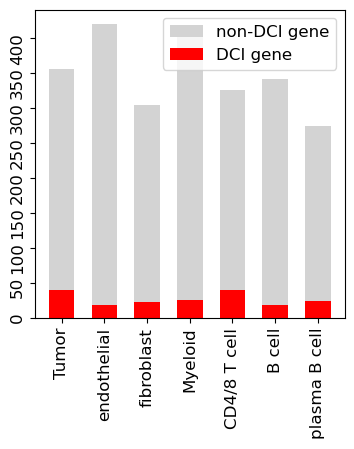

In [21]:
def get_DCIgene_barplot(spcDCI,
                       states_plot=None,
                       ax=None):
    if states_plot is None:
        states_plot = spcDCI.states
        
    DCI_df = spcDCI.DCI_df
    chitest_df = spcDCI.chitest_df
    
    total_genes = []
    for state in states_plot:
        total_genes.append(
            len(np.unique(chitest_df[chitest_df['state']==state]['gene'])))
    
    DCI_gene_counts = []
    for state in states_plot:
        DCI_gene_counts.append(len(np.unique(DCI_df[DCI_df['state']==state]['gene'])))
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    ax.bar(x=states_plot, height=total_genes, color='lightgrey', 
           width=.6, label='non-DCI gene')
    ax.bar(x=states_plot, height=DCI_gene_counts, 
           color=['red'], width=.6, label='DCI gene')
    ax.tick_params(rotation=90)
    ax.legend()
get_DCIgene_barplot(spcDCI,
                   states_plot=['Tumor', 'endothelial', 'fibroblast',
                                'Myeloid', 'CD4/8 T cell', 
                                'B cell', 'plasma B cell'])
    